In [ ]:
 # referenced & implemented for my own custom dataset relevant for Car Design feature detection.
# https: // debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/
# https://github.com/HyungjoByun/Projects/blob/main/Faster%20RCNN/FasterRCNN_Train.ipynb

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/CS492I/final
!ls

/content/drive/MyDrive/CS492I/final
Car_Dataset    engine.py		model	     test_predictions
Car_Dataset_2  FasterRCNN-Resnet.ipynb	model.py     train.py
checkpoint     IG			outputs      utils.py
config.py      inference.py		__pycache__  xml_to_csv.py
dataset        inference_video.py	runs
datasets.py    mAP			test_data


In [7]:
!pip install albumentations==0.4.6

In [13]:
!python train.py

Number of training samples: 285
Number of validation samples: 29


EPOCH 1 of 50
Training
  0% 0/143 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Loss: 0.3866: 100% 143/143 [00:41<00:00,  3.44it/s]
Validating
Loss: 0.9450: 100% 15/15 [00:02<00:00,  5.61it/s]
Epoch # 0 train loss: 0.505
Epoch # 0 validation loss: 0.932
Took 0.741 minutes for epoch 0

Best validation loss: 0.9323385755221049

Saving best model for epoch: 1


EPOCH 2 of 50
Training
Loss: 0.5573: 100% 143/143 [00:41<00:00,  3.46it/s]
Validating
Loss: 0.8679: 100% 15/15 [00:02<00:00,  5.57it/s]
Epoch # 1 train loss: 0.512
Epoch # 1 validation loss: 0.907
Took 0.736 minutes for epoch 1

Best validation loss: 0.9067083915074666

Saving best model f

In [28]:
!python inference.py

Test instances: 23
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Image 1 done
--------------------------------------------------
Image 2 done
--------------------------------------------------
Image 3 done
--------------------------------------------------
Image 4 done
--------------------------------------------------
Image 5 done
--------------------------------------------------
Image 6 done
--------------------------------------------------
Image 7 done
--------------------------------------------------
Image 8 done
--------------------------------------------------
Image 9 done
--------------------------------------------------
Image 10 done
--------------------------------------------------
Image 11 done
--------------

In [34]:
!python inference_video.py

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Average FPS: 12.805


In [ ]:
!pip install imgaug --upgrade

# mAP Calculation

reference coming from HyungJo Byun's blogpost
[링크 텍스트](https://hyungjobyun.github.io/machinelearning/FasterRCNN2/#dataset%EC%A4%80%EB%B9%84--%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC-import)

## Loading packages

In [14]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms 
import torch.optim as optim 

from collections import OrderedDict
from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import albumentations as A
import imgaug as ia 
from imgaug import augmenters as iaa 
from PIL import Image

import os 
import glob as glob 
import time 
from xml.etree import ElementTree as et 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(device)

cuda


In [15]:
def xml_parser(xml_path):
    xml_path = xml_path 

    xml = open(xml_path, 'r')
    tree = et.parse(xml)
    root = tree.getroot()

    size = root.find('size')

    file_name = root.find('filename').text

    object_name = []
    bbox = [] 

    objects = root.findall('object') 
    for _object in objects:
        name = _object.find('name').text
        object_name.append(name)
        bndbox = _object.find('bndbox')
        a_bbox = [] 
        xmin = bndbox.find('xmin').text
        a_bbox.append(int(float(xmin)))
        ymin = bndbox.find('ymin').text
        a_bbox.append(int(float(ymin)))
        xmax = bndbox.find('xmax').text
        a_bbox.append(int(float(xmax)))
        ymax = bndbox.find('ymax').text
        a_bbox.append(int(float(ymax)))
        bbox.append(a_bbox)

    return file_name, object_name, bbox

def makeBox(image, bbox, objects):
    image = image.copy()
    for i in range(len(objects)):
        cv2.rectangle(image, 
                      (int(bbox[i][0]), int(bbox[i][1])), 
                      (int(bbox[i][2]), int(bbox[i][3])),
                      (0, 255, 0), 1)
        
        cv2.putText(image, 
                    objects[i], 
                    (int(bbox[i][0]), int(bbox[i][1])-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    return image

In [16]:
xml_list = os.listdir('/content/drive/MyDrive/CS492I/final/Car_Dataset_2/Annotations/')
xml_list.sort()

label_set = set()

for i in range(len(xml_list)):
    xml_path = "/content/drive/MyDrive/CS492I/final/Car_Dataset_2/Annotations/" + str(xml_list[i])
    file_name, object_name, bbox = xml_parser(xml_path)
    for name in object_name:
        label_set.add(name)

label_set = sorted(list(label_set))

label_dic = {}
for i, key in enumerate(label_set):
    label_dic[key] = (i+1)
print(label_dic)

{'aero': 1, 'bodysurface': 2, 'compact': 3, 'coupe': 4, 'coupe-convertible': 5, 'diffuser': 6, 'dlo': 7, 'fender': 8, 'foglamp': 9, 'frontbumper': 10, 'grill': 11, 'hatchback': 12, 'headlamp': 13, 'hood': 14, 'mirror': 15, 'opening': 16, 'rearbumper': 17, 'rearlamp': 18, 'rocker': 19, 'sedan': 20, 'spoiler': 21, 'sports': 22, 'suv': 23, 'suv-coupe': 24, 'wagon': 25, 'wheel': 26}


In [17]:
class Car_Dataset(Dataset):
    def __init__(self, xml_list, len_data):

        self.to_tensor = transforms.ToTensor()
        self.len_data = len_data 
        self.xml_list = xml_list
        self.xml_path = xml_path
        self.flip = iaa.Fliplr(0.5)
        self.resize = iaa.Resize({"shorter-side": 512, "longer-side": "keep-aspect-ratio"})
    
    def __len__(self):
        return self.len_data
        
    def __getitem__(self, idx):
        
        xml_path = "/content/drive/MyDrive/CS492I/final/Car_Dataset_2/Annotations/" + str(xml_list[idx])
        file_name, object_name, bbox = xml_parser(xml_path)

        img_path = "/content/drive/MyDrive/CS492I/final/Car_Dataset_2/JPEGImages/" + str(file_name)

        image = Image.open(img_path).convert('RGB')
        image = np.array(image)

        image, bbox = self.flip(image = image, bounding_boxes = np.array([bbox]))
        image, bbox = self.resize(image = image,bounding_boxes = bbox)
        bbox = bbox.squeeze(0).tolist()
        image = self.to_tensor(image)
        
        boxes = torch.tensor(bbox, device=device)
        labels = torch.tensor([label_dic[x] for x in object_name], dtype=torch.int64, device = device)
        
        targets = []
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        targets.append(target)       
                    
        return image, targets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[{'boxes': tensor([[[238, 292, 279, 352],
         [ 42, 290,  72, 342],
         [ 83, 266, 112, 274],
         [146, 205, 275, 250],
         [372, 274, 388, 304],
         [478, 272, 486, 296],
         [214, 246, 350, 296],
         [ 26, 246, 126, 286],
         [284, 285, 484, 340],
         [ 24, 194, 486, 368],
         [ 90, 248, 222, 337]]], device='cuda:0'), 'labels': tensor([[25, 25,  1,  7, 18, 18,  8,  8, 17,  4,  2]], device='cuda:0')}]


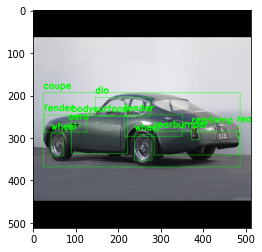

In [ ]:
dataset = Car_Dataset(xml_list, len_data=100)
dataloader = DataLoader(dataset, shuffle=True)

for i, (image, targets) in enumerate(dataloader):
    test_image = image
    test_target = targets 
    if i == 5 : break

print(test_target)

labels = test_target[0]['labels'].squeeze(0)
objects = []
for label in labels:
    objects.append([k for k, v in label_dic.items() if v == label][0])

plot_image = makeBox(test_image.squeeze(0).permute(1,2,0).numpy(), test_target[0]['boxes'].squeeze(0), objects)
plt.imshow(plot_image)

In [18]:
def make_info_txt(file_name, object_name, bbox, mode, scores = None):
    if mode == 'gt':
        with open(f"/content/drive/MyDrive/CS492I/final/mAP/input/ground-truth/{file_name[:-4]}.txt", "w") as f:
            for i in range(len(object_name)):
                f.write("{} ".format(object_name[i]) + " ".join(map(str, map(int, bbox[i]))) + "\n")

    if mode == 'rt':
        assert scores != None
        with open(f"/content/drive/MyDrive/CS492I/final/mAP/input/detection-results/{file_name[:-4]}.txt", "w") as f:
            for i in range(len(object_name)):
                f.write("{} ".format(object_name[i])+"{} ".format(scores[i])+" ".join(map(str,map(int,bbox[i])))+"\n")
                

In [19]:
def evaluation(xml_list, new = False):
  if new == True:
    print("Clear Directory")
    filelist = [ f for f in os.listdir("/content/drive/MyDrive/CS492I/final/mAP/input/ground-truth/")]
    for f in filelist:
      os.remove(os.path.join("/content/drive/MyDrive/CS492I/final/mAP/input/ground-truth/", f)) 
    
    filelist = [ f for f in os.listdir("/content/drive/MyDrive/CS492I/final/mAP/input/detection-results/")]
    for f in filelist:
      os.remove(os.path.join("/content/drive/MyDrive/CS492I/final/mAP/input/detection-results/", f)) 

    print("Evaluating")
    model.eval()
    for i in range(len(xml_list)):
      xml_path = "/content/drive/MyDrive/CS492I/final/Car_Dataset_2/Annotations/"+str(xml_list[i])
      file_name, object_name, bbox = xml_parser(xml_path)
    #   print(file_name)
      image_path = "/content/drive/MyDrive/CS492I/final/Car_Dataset_2/JPEGImages/"+str(file_name)

      test_image = Image.open(image_path).convert("RGB")
      test_image = np.array(test_image)
    #   print(test_image)
      resize = iaa.Resize({"shorter-side": 1024, "longer-side": "keep-aspect-ratio"})
      to_tensor = torchvision.transforms.ToTensor()
      
      test_image,bbox = resize(image = test_image,bounding_boxes = np.array([bbox]))
      make_info_txt(file_name, object_name, bbox.squeeze(0),mode='gt')

      
      test_image = to_tensor(test_image).unsqueeze(0)
      predictions = model(test_image.to(device))
      object_name = []
      boxes = predictions[0]['boxes']
      labels = predictions[0]['labels']
      scores = predictions[0]['scores']
      for lb in labels:
        object_name.append([k for k, v in label_dic.items() if v == lb][0])
      
      make_info_txt(file_name, object_name, boxes, mode='rt', scores = scores)
  
  print("Result")
  f = os.popen("python /content/mAP/main.py --no-animation ") #openCV작동 안해서 --no-animation
  print(f.read())

In [35]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


num_classes = 27

def create_model(NUM_CLASSES):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

def get_vgg(num_classes):
    backbone = torchvision.models.vgg16(pretrained=True).features[:-1]
    backbone_out = 512
    backbone.out_channels = backbone_out

    resolution = 7
    anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((128, 256, 512),),aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=resolution, sampling_ratio=2)

    box_head = torchvision.models.detection.faster_rcnn.TwoMLPHead(in_channels= backbone_out*(resolution**2),representation_size=4096) 
    box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(4096,26) 

    model = torchvision.models.detection.FasterRCNN(backbone, num_classes=None,
                    min_size = 600, max_size = 1000,
                    rpn_anchor_generator=anchor_generator,
                    rpn_pre_nms_top_n_train = 6000, rpn_pre_nms_top_n_test = 6000,
                    rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=300,
                    rpn_nms_thresh=0.7,rpn_fg_iou_thresh=0.7,  rpn_bg_iou_thresh=0.3,
                    rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                    box_roi_pool=roi_pooler, box_head = box_head, box_predictor = box_predictor,
                    box_score_thresh=0.6, box_nms_thresh=0.7,box_detections_per_img=300,
                    box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                    box_batch_size_per_image=128, box_positive_fraction=0.25
                    )
    
    return model

def get_mobilenet(num_classes):

    backbone = torchvision.models.mobilenet_v3_large(pretrained=False, progress=True, pretrained_backbone=False).features
    backbone.out_channels = 960 #1280 vgg 
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512), ), 
                                                aspect_ratios=((0.5, 1.0, 2.0), ))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator,
                        box_roi_pool = roi_pooler)

    return model 

model = create_model(num_classes)
model.to(device)
# checkpoint = torch.load('/content/drive/MyDrive/CS492I/final/outputs/best_model_resnet_v3.pth', map_location=device) #load model from location 
# model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(torch.load('/content/drive/MyDrive/CS492I/final/outputs//best_model_mobilenetv3_1.pth'))

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [36]:
evaluation(xml_list, new=True) # create file

Clear Directory
Evaluating
Result

